In [1]:
# Calling libraries:
from __future__ import division
get_ipython().magic('matplotlib inline')
import numpy as np
from time import time
from pylab import plot, show, legend
import matplotlib.pyplot as plt
import math 
from scipy.stats import *
from time import time
from common_functions import *
from functions_2d import *

### Define functions and generate data

In [2]:
alpha = 1/2; sigma = 0.5; sigma_error = 0.5
theta = [alpha, sigma, sigma_error]

x_0 = [ 0.2, 0.2 ]
delta = 10**-1; dt = delta/10
T = 10**3

hidden, observed = simulate_data(theta, x_0, delta, dt, T)

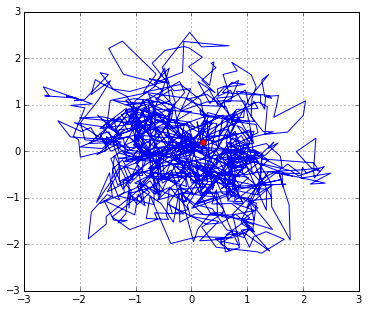

In [3]:
plt.rcParams['figure.figsize'] = (6, 5)
plt.plot(hidden[:,0], hidden[:,1])
plt.plot(hidden[0,0], hidden[0,1], 'ro')
plt.grid(True)

### Does it track?

* Starting at wrong positions

In [4]:
theta_0 = theta + uniform.rvs(-0.25,0.25,3)

N = 10**3
initial = np.random.randn(N,2)
particles, weights, log_NC = bootstrap_PF(delta, dt, g, observed, theta_0, initial, N)

C:\Python34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


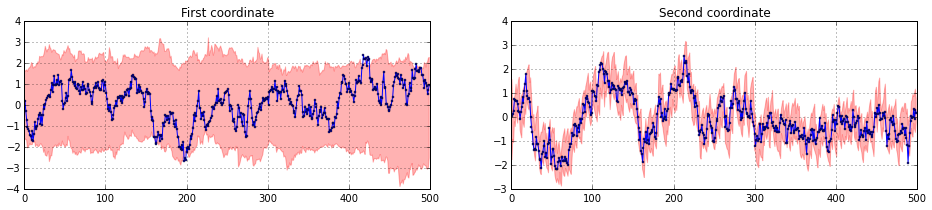

In [5]:
t_start, t_end = 0, 500
plt.rcParams['figure.figsize'] = (16,3)
titles = ['First coordinate', 'Second coordinate']
for i in range(2) :
    plt.subplot(1,2,i+1)
    plt.plot(np.arange(t_start,t_end), hidden[t_start:t_end,i], 'bo-', markersize=2)
    plt.fill_between(np.arange(t_start,t_end), np.percentile(particles[t_start:t_end,:,i],axis=1,q=5), 
                     np.percentile(particles[t_start:t_end,:,i],axis=1,q=95), color='red', alpha=.3)
    plt.grid(True)
    plt.title(titles[i])

### See is this approximate initial points scheme works for a short segment. 

* True starting position is known because we know true trajectory.

In [6]:
n_mcmc = 10**4
scale = np.asarray([0.5, 0.5, 0])
prior_mean, prior_sd = np.copy(theta), np.asarray([0.5, 0.5, 0])

In [8]:
round(representative_jumps(delta, dt, g, theta, scale=scale, y=observed[120:220], 
                     x_0=hidden[119], n_particles=150, rep=25, n_jumps=20),1)

0.90000000000000002

#### First run PMCMC on a short initial segment to determine the value of $\theta$ which will be used later to generate the starting points

In [8]:
start = time()
theta_chain = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, y=observed[:50], scale=scale, 
                                   theta_0=theta, x_0=x_0, n_particles=200, n_mcmc=10**3)    
print( round((time() - start)/60, 2), 'minutes' )

1.03 minutes


#### Run true MCMC

In [25]:
start = time()
theta_chain_true = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, y=observed[120:220], 
                                        scale=2*scale, theta_0=theta, 
                                        x_0=hidden[119], n_particles=150, n_mcmc=10**4) 
print( round((time() - start)/60, 2), 'minutes' )

18.69 minutes


In [26]:
print(round(gewer_estimate_IAT(np.log(theta_chain_true[:,0])),1), 
      round(gewer_estimate_IAT(np.log(theta_chain_true[:,1])),1))

9.2 9.1


#### Run approximate MCMC

In [27]:
start = time()

#chose starting points for particle filter:
N = 10**3
result = bootstrap_PF(delta, dt, g, y=observed[115:120], 
                      theta=np.mean(theta_chain, axis=0), 
                      x_0=np.random.randn(N,2)**2, N=N)
XX, w = result[0], result[1]/np.sum(result[1])
n_particles = 150
initial = XX[-1, np.random.choice(a=N,size=n_particles,p=w)]

# run pseudo-marginal MCMC:
theta_chain_aprx = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, y=observed[120:220], scale=scale, 
                                        theta_0=theta, x_0=initial, n_particles=150, n_mcmc=10**4)
print( round((time() - start)/60, 2), 'minutes' )

18.54 minutes


#### Compare

In [28]:
for i in np.arange(0,2) : 
    print(round(gewer_estimate_IAT(np.log(theta_chain_true[1000:,i])),1), 
          round(gewer_estimate_IAT(np.log(theta_chain_aprx[1000:,i])),1))

9.1 8.6
9.2 13.1


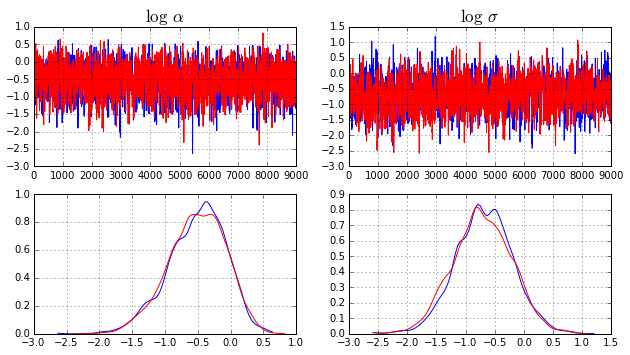

In [30]:
plt.rcParams['figure.figsize'] = (16,5.5)
fig = plt.figure()

names = [r'$\log \, \alpha$', r'$\log \, \sigma$', r'$\log \, \sigma_\epsilon$']

for i in np.arange(0,2) :
    plt.subplot(2,3,i+1)
    plt.plot(np.log(theta_chain_true[1000:,i]), color='b')
    plt.plot(np.log(theta_chain_aprx[1000:,i]), color='r')
    plt.grid(True)
    plt.title(names[i], fontsize=17)

for i in np.arange(0,2) :
    plt.subplot(2,3,4+i) 
    x_vals = np.linspace(start=np.min(np.log(theta_chain_true[1000:,i])), 
                         stop=np.max(np.log(theta_chain_true[1000:,i])), num=100)
    plt.plot(x_vals, gaussian_kde(np.log(theta_chain_true[1000:,i])) (x_vals), color='b') 
    x_vals = np.linspace(start=np.min(np.log(theta_chain_aprx[1000:,i])), 
                         stop=np.max(np.log(theta_chain_aprx[1000:,i])), num=100)
    plt.plot(x_vals, gaussian_kde(np.log(theta_chain_aprx[1000:,i])) (x_vals), color='r')
    plt.grid(True)

#### Okay, good. 

In [32]:
scale = np.asarray([0.5, 0.5, 0])
prior_mean, prior_sd = np.copy(theta), np.asarray([0.5, 0.5, 0])

In [40]:
for n in np.arange(1,6) :
    print(representative_jumps(delta, dt, g, theta, scale=scale, y=observed[:n*100], 
                     x_0=x_0, n_particles=100, rep=50, n_jumps=50))

1.88112633275
2.51883305364
4.01682213864
5.76713051452
6.69062932204


### Pseudo-marginal MCMC on chunks of HMM:

In [49]:
def segmented_pseudo_marginal(prior_mean, prior_sd, delta, dt, g, theta_0, 
                              scale, x_0, y, n_mcmc, N_particles, segment_size=50) :
    
    T = len(y)
    n_segments = int(T/segment_size)
    
    theta_chains = np.zeros((n_segments, n_mcmc+1, len(theta)))
    
    """
    Run pseudo-margial MCMC on a short initial segment to determine the value of 
    theta which will be used later to generate the starting points
    """
    theta_chain = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, y[:segment_size], 
                                       scale, theta_0, x_0, N_particles[0], n_mcmc) 
    theta_chains[0] = theta_chain
    
    """ Iterate over segments """
    for n in np.arange(1,n_segments) :
        
        """
        Generate starting points for particle filter
        """
        N = 10**3
        result = bootstrap_PF(delta, dt, g, y[n*segment_size-5:n*segment_size], 
                              theta_0, np.random.randn(N,2)**2, N)
        XX, w = result[0], result[1]/np.sum(result[1])
        initial = XX[-1, np.random.choice(a=N,size=N_particles[n],p=w)]
        """
        Run pseudo-marginal MCMC with these starting points on segments
        """
        theta_chain_aprx = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, 
                                                y[n*segment_size:(n+1)*segment_size], 
                                                scale, theta_0, initial, N_particles[n], n_mcmc)
        theta_chains[n] = theta_chain_aprx
    
    return theta_chains 

### MCMC on parts:

In [50]:
rep_vars = np.zeros(9)
for n in np.arange(2,11) :
    rep_vars[n-2] = representative_jumps(delta, dt, g, theta, scale=scale, y=observed[(n-1)*50:n*50], 
                                         x_0=hidden[(n-1)*50-1], n_particles=50, rep=50, n_jumps=50)
print(np.round(rep_vars,2))

[ 0.71  1.47  1.69  1.86  1.69  0.88  0.95  1.    1.04]


In [51]:
N_particles = np.append(50,np.round(50*rep_vars).astype(int))

In [52]:
start = time()
theta_chains = segmented_pseudo_marginal(prior_mean, prior_sd, delta, dt, g, theta, 
                                         scale, x_0, y=observed[:500], n_mcmc=10**4, 
                                         N_particles=N_particles, segment_size=50)
print( round((time() - start)/60, 2), 'minutes' )

60.45 minutes


In [53]:
for i in range(np.shape(theta_chains)[0]):
    print(round(gewer_estimate_IAT(theta_chains[i,:,0]),1),
          round(gewer_estimate_IAT(theta_chains[i,:,1]),1))

11.8 18.5
10.5 21.8
8.0 12.1
10.4 10.6
8.5 13.0
11.3 11.5
12.7 11.8
10.4 14.8
13.3 15.6
11.8 11.6


In [55]:
theta_chains[:,burn_in:,:].mean(axis=(0,1))

array([ 0.57674251,  0.56954833,  0.5       ])

### MCMC on full:

In [57]:
representative_jumps(delta, dt, g, theta, scale=scale, y=observed[:500], 
                     x_0=x_0, n_particles=500, rep=50, n_jumps=50)

1.187953011054647

In [59]:
start = time()
theta_chain_full = pseudo_marginal_MCMC(prior_mean, prior_sd, delta, dt, 
                                        y=observed[:500], scale=scale, theta_0=theta, 
                                        x_0=x_0, n_particles=600, n_mcmc=10**4)    
print( round((time() - start)/60, 2), 'minutes' )

169.95 minutes


In [61]:
print(round(gewer_estimate_IAT(theta_chain_full[:,0]),1),
      round(gewer_estimate_IAT(theta_chain_full[:,1]),1))

7.7 17.1


In [62]:
theta_chain_full[burn_in:,:].mean(axis=0)

array([ 0.54508833,  0.54453865,  0.5       ])

In [85]:
thinning = (1000 + 20*np.arange(9000/20)).astype(int)

In [86]:
theta_chains[:,thinning,0].var(axis=1).mean(), theta_chain_full[thinning,0].var()

(0.077025306062924265, 0.018838553883310623)

In [87]:
theta_chains[:,thinning,1].var(axis=1).mean(), theta_chain_full[thinning,1].var()

(0.090138475700354978, 0.079972579397068588)

In [90]:
prior_sd

array([ 0.5,  0.5,  0. ])

In [74]:
def f(x) :
    return x**2

In [77]:
print(f(theta_chains[:,burn_in:,:]).mean(axis=(0,1)) - theta_chain_full[burn_in:,:].mean(axis=0)**2)
print(f(theta_chain_full[burn_in:,:]).mean(axis=0) - theta_chain_full[burn_in:,:].mean(axis=0)**2)

[ 0.12412925  0.12060666  0.        ]
[ 0.01874664  0.07186165  0.        ]
